# (Try to) identify signals of gentrification from Airbnb data

In [1]:
import os
import re
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from scipy.stats import zscore, gaussian_kde
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from datetime import datetime
import seaborn as sns
from shapely.geometry import Point
from geopandas import GeoDataFrame
from IPython.core.pylabtools import figsize
from fontTools.varLib.interpolatableHelpers import matching_for_vectors
import folium
import branca.colormap as cm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sys

sys.path.insert(1, '../')
from PlottingFunctions import *

cmap = plt.get_cmap('plasma', 5)  # 5 discrete colors
plot_colors = [cmap(i) for i in range(5)]
plot_colors[4] = 'gold'

city='manchester'

### Get just Manchester LSOAs

In [2]:
lsoas =  gpd.read_file('../../../data/SpatialData/LSOAs_2011/LSOA_2011_EW_BSC_V4.shp')
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
manchester_lsoas=lsoas[lsoas['LSOA11NMW'].str.contains(manc_lads_pattern)]

### Read in socioeconomic indicator data

In [3]:
indicators = pd.read_csv("../../../data/GentrificationIndex/SocioEconomicData/Eng_imputedV3.csv") # for the whole o England
# Get just for Manchester
indicators_manchester = indicators[indicators['LA_NAME'].str.contains(manc_lads_pattern)].copy()
indicators_manchester = indicators_manchester.rename(columns={"LSOA": 'LSOA11CD'})
del indicators_manchester['Churn_2020']
indicators_manchester.reset_index(inplace=True, drop=True)
len(indicators_manchester)

1673

### Apply StandardScaler to indicator data

In [4]:
numeric_cols = indicators_manchester.columns
numeric_cols = numeric_cols.drop(['LSOA11CD', 'LA_NAME'])

standard_scaler = StandardScaler()
scaled_standard = standard_scaler.fit_transform(indicators_manchester[numeric_cols])

# Convert scaled values back to DataFrame and concatenate with original non-numeric columns
scaled_standard_df = pd.DataFrame(scaled_standard, columns=numeric_cols)
indicators_manchester_standard = pd.concat([indicators_manchester[['LSOA11CD', 'LA_NAME']], scaled_standard_df], axis=1)

### Join the gentrification index indicators to the other socio-economic indicators

In [5]:
# g_index = pd.read_csv("../../data/ManchesterIndex/manc_index.csv") 
# # g_index_df = g_index.merge(central_lsoas[['LSOA11NM', 'geometry']], on='LSOA11NM', how='left')

In [6]:
# g_index_cols_to_join = ['LSOA11CD', 'gi_n', 'rmd_z', 'house_price_z', 'BME_z', 'churn_z', 'wage_change_z',
#     'rmd', 'hp_pc_change', 'poc_ppt', 'chn2013', 'wage_change']

# # Merge the specified columns into indicators_manchester
# indicators_manchester_standard = indicators_manchester_standard.merge( g_index[g_index_cols_to_join],on='LSOA11CD', how='left')

## Get gentrification scores, convert string to categorical

In [7]:
base_dir = os.path.expanduser(f"../../../data/AirbnbData/airbnb-{city}/")
gentrication_cat_df = pd.read_csv(base_dir + 'airbnb_gentrification_scores_categorical_combined_listings_filtered_01.csv')
mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
gentrication_cat_df['gentrification_prediction_code'] = gentrication_cat_df['gentrification_prediction'].map(mapping)

### Convert to a geodataframe

In [8]:
gentrication_cat_df['geometry'] = gentrication_cat_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gentrication_cat_gdf = gpd.GeoDataFrame(gentrication_cat_df, geometry='geometry', crs="EPSG:4326")
gentrication_cat_gdf = gentrication_cat_gdf[['LSOA11NM', 'gentrification_prediction_code']]
gentrication_cat_gdf = gentrication_cat_gdf.merge(manchester_lsoas[['LSOA11NM', 'LSOA11CD']], on='LSOA11NM', how='left')

### Find the most common score in each LSOA

In [9]:
lsoa_scores = pd.DataFrame({'score': gentrication_cat_gdf.groupby("LSOA11CD")["gentrification_prediction_code"].agg(lambda x: pd.Series.mode(x).iloc[0]), 
              'count':gentrication_cat_gdf.groupby("LSOA11CD")["gentrification_prediction_code"].count()})
lsoa_scores.reset_index(inplace=True)

In [10]:
indicators_manchester_standard = indicators_manchester_standard.merge(lsoa_scores, on='LSOA11CD', how='right')
indicators_manchester_standard.sort_values(by='score', inplace=True)

In [11]:
# numeric_cols = indicators_manchester.columns
# numeric_cols = numeric_cols.drop(['LSOA11CD', 'LA_NAME', 'score', 'count'])

# standard_scaler = StandardScaler()
# scaled_standard = standard_scaler.fit_transform(indicators_manchester[numeric_cols])

# # Convert scaled values back to DataFrame and concatenate with original non-numeric columns
# scaled_standard_df = pd.DataFrame(scaled_standard, columns=numeric_cols)
# indicators_manchester_standard = pd.concat([indicators_manchester[['LSOA11CD', 'LA_NAME', 'score', 'count']], scaled_standard_df], axis=1)

## Rose plots

In [12]:
def plot_mean_rose_plot(ax, indicators, variables, color, title=None, show_std=True, fixed_max=None):
    # Calculate means and standard deviations
    means = [float(indicators[col].mean()) for col in variables]
    std_devs = [float(indicators[col].std()) for col in variables]
    
    # Calculate angles for the radar plot
    num_vars = len(variables)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    
    # Close the plot loop
    angles += angles[:1]
    means += means[:1]
    std_devs += std_devs[:1]
    
    std_upper = [m + s for m, s in zip(means, std_devs)]
    std_lower = [m - s for m, s in zip(means, std_devs)]
    
    # Plot mean values
    ax.plot(angles, means, label='Mean', color=color, linewidth=2)
    ax.scatter(angles, means, color=color, s=20)
    
    if show_std:
        # Plot ± std deviation lines
        ax.plot(angles, std_upper, label='Mean + Std', color=color, linestyle='--', linewidth=1)
        ax.scatter(angles, std_upper, color=color, s=20)
        ax.plot(angles, std_lower, label='Mean - Std', color=color, linestyle='--', linewidth=1)
        ax.scatter(angles, std_lower, color=color, s=20)
        
        # Fill between std ranges
        ax.fill(angles, std_upper, color=color, alpha=0.3)
        ax.fill(angles, std_lower, color=color, alpha=0.3)
    
    # Ticks and labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(variables, fontsize=10)
    ax.set_yticklabels([])

    # Optional: set title
    if title:
        ax.set_title(title, fontsize=12, ha='center')

    # Optional: fix radial axis max
    if fixed_max:
        ax.set_ylim(0, fixed_max)


In [13]:
# Precompute global max
# global_max = 0
# for gentr_class in indicators_manchester_standard['gentrification_prediction_code'].unique():
#     class_data = indicators_manchester_standard[
#         indicators_manchester_standard['gentrification_prediction_code'] == gentr_class]
#     max_val = class_data[numeric_cols].mean().max() + class_data[numeric_cols].std().max()
#     global_max = max(global_max, max_val)
# global_max *= 1.1
# global_max= 2

In [14]:
original_indicators = indicators_manchester_standard.iloc[:,:64]
original_indicators = original_indicators.merge(lsoa_scores, on='LSOA11CD', how='right')
original_indicators.sort_values(by='score', inplace=True)

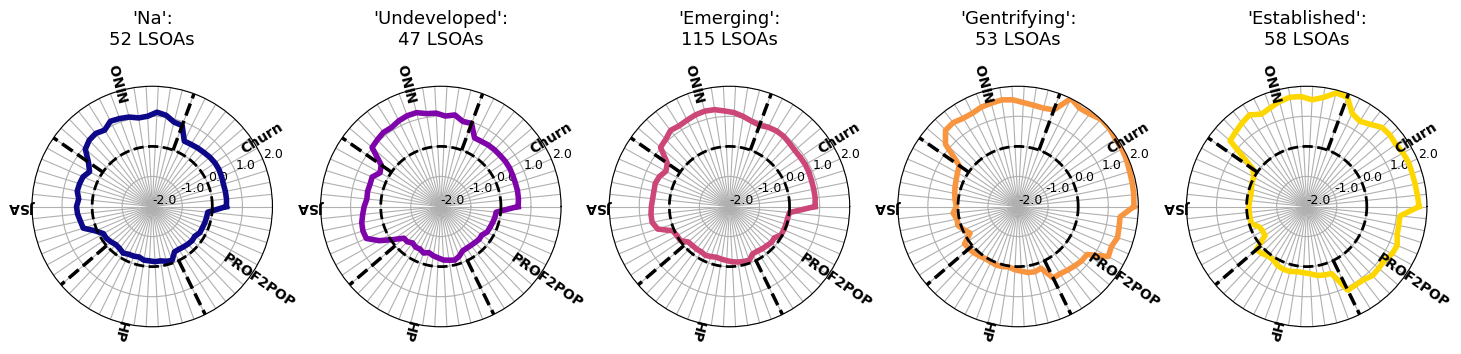

In [15]:
fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=5, nrows=1, figsize=(18, 8), sharex=True, sharey=True)

for gentr_class, ax in enumerate(axs.flatten()):
    class_data = indicators_manchester_standard[
        indicators_manchester_standard['score'] == gentr_class]
    if class_data.empty:
        ax.set_axis_off()
    else:
        key = [k for k, v in mapping.items() if v == gentr_class][0]
        plot_flexible_radar( ax, class_data, numeric_cols,
            color=plot_colors[gentr_class],  title=f"'{key}':\n{len(class_data)} LSOAs", show_std=False, fixed_max=2)
    ax.plot(np.linspace(0, 2 * np.pi, 100), np.zeros(100), color='black', linewidth=2, linestyle='dashed')

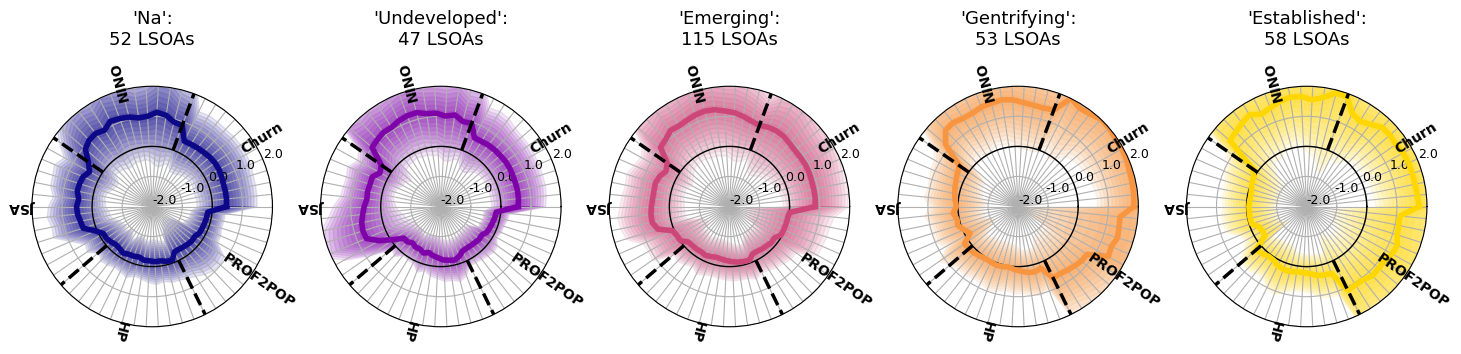

In [16]:
fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=5, nrows=1, figsize=(18, 8), sharex=True, sharey=True)

for gentr_class, ax in enumerate(axs.flatten()):
    ax.plot(np.linspace(0, 2 * np.pi, 100), np.zeros(100), color='black', linewidth=1)
    class_data = indicators_manchester_standard[
        indicators_manchester_standard['score'] == gentr_class]
    if class_data.empty:
        ax.set_axis_off()
    else:
        key = [k for k, v in mapping.items() if v == gentr_class][0]
        plot_flexible_radar( ax, class_data, numeric_cols,
            color=plot_colors[gentr_class],  title=f"'{key}':\n{len(class_data)} LSOAs", show_std=True, fixed_max=2)

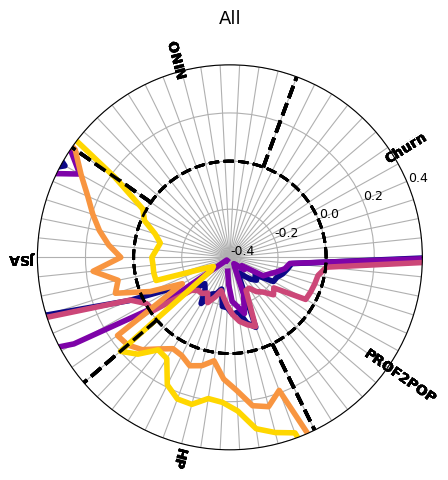

In [17]:
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': 'polar'}, sharey=True)
for gentr_class in indicators_manchester_standard['score'].unique():
    gentr_class=int(gentr_class)
    class_data = indicators_manchester_standard[indicators_manchester_standard['score'] == gentr_class]
    if class_data.empty:
        ax.set_axis_off()
    else:
        key = [k for k, v in mapping.items() if v == gentr_class][0]
        plot_flexible_radar(ax, class_data, numeric_cols,
            color=plot_colors[gentr_class],  title='All', show_std=False, fixed_max=0.4)
    ax.plot(np.linspace(0, 2 * np.pi, 100), np.zeros(100), color='black', linewidth=2, linestyle='dashed')

In [18]:
lsoa_scores = lsoa_scores.merge(manchester_lsoas, on='LSOA11CD', how='left')
lsoa_scores_gdf = gpd.GeoDataFrame(lsoa_scores, geometry='geometry', crs="EPSG:27700")

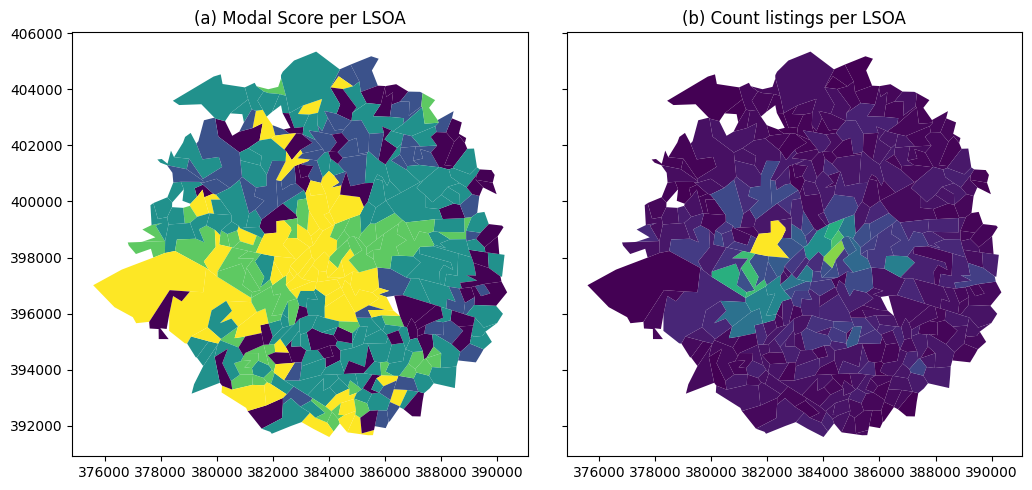

In [35]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1]}, sharey=True, sharex=True)  # Ensure equal subplot sizes
lsoa_scores_gdf.plot(ax = axs[0],column =  "score")
axs[0].set_title("(a) Modal Score per LSOA")
lsoa_scores_gdf.plot(ax = axs[1],column = "count");
axs[1].set_title("(b) Count listings per LSOA");
plt.tight_layout()
fig.subplots_adjust(wspace=-0.2)

In [21]:
import folium
from folium import Choropleth, LayerControl, GeoJson
import geopandas as gpd

# Ensure GeoDataFrame is in WGS84 for Folium
lsoa_scores_gdf = lsoa_scores_gdf.to_crs(epsg=4326)

# Create base map
m = folium.Map(location=[lsoa_scores_gdf.geometry.centroid.y.mean(),
              lsoa_scores_gdf.geometry.centroid.x.mean()],zoom_start=11)

# --- Score Layer ---
score_map = Choropleth(
    geo_data=lsoa_scores_gdf,
    data=lsoa_scores_gdf,
    columns=['LSOA11CD', 'score'],
    key_on='feature.properties.LSOA11CD',
    fill_color='YlGnBu',
    fill_opacity=0.9,
    line_opacity=0.2,
    legend_name='Score'
)
score_map.add_to(m)

# Add boundaries and labels as a GeoJson layer for score
GeoJson(
    lsoa_scores_gdf,
    name='Score',
    tooltip=folium.GeoJsonTooltip(fields=['LSOA11CD', 'score'])
).add_to(m)

# Add layer control
LayerControl().add_to(m)

# Display map
m


/tmp/ipykernel_22818/2083022428.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[lsoa_scores_gdf.geometry.centroid.y.mean(),
/tmp/ipykernel_22818/2083022428.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lsoa_scores_gdf.geometry.centroid.x.mean()],zoom_start=11)


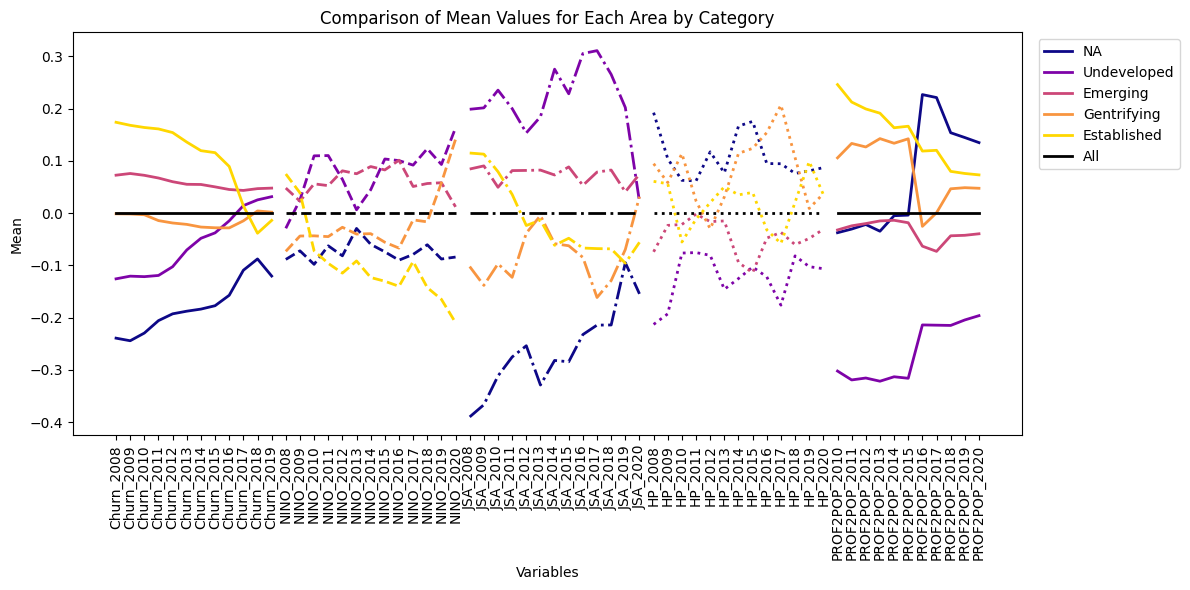

In [22]:
from matplotlib.lines import Line2D

# Define variable categories (based on column names or your own grouping logic)
variable_categories = {
    'Churn': [col for col in indicators_manchester_standard.columns if 'Churn' in col],
    'NINO': [col for col in indicators_manchester_standard.columns if 'NINO' in col],
    'JSA': [col for col in indicators_manchester_standard.columns if 'JSA' in col],
    'HP': [col for col in indicators_manchester_standard.columns if 'HP' in col],
    'PROF2POP': [col for col in indicators_manchester_standard.columns if 'PROF2POP' in col]
}

# Compute mean and std for all areas
areas = { "NA": indicators_manchester_standard[indicators_manchester_standard['score'] == 0],
    "Undeveloped": indicators_manchester_standard[indicators_manchester_standard['score'] == 1],
    "Emerging": indicators_manchester_standard[indicators_manchester_standard['score'] == 2],
    "Gentrifying": indicators_manchester_standard[indicators_manchester_standard['score'] == 3],
    "Established": indicators_manchester_standard[indicators_manchester_standard['score'] == 4],
    'All': indicators_manchester_standard}

# Compute mean and std for all areas
stats = {}
for area, df in areas.items():
    stats[area] = {
        "Mean": df.drop(columns=['LSOA11CD', 'LA_NAME', 'score']).mean(),
        "Std": df.drop(columns=['LSOA11CD', 'LA_NAME', 'score']).std(),
        'len': len(df)}

# Plot means for all areas, with grouping by categories
plt.figure(figsize=(12, 6))

# Different line styles for categories
category_styles = {'Churn': '-', 'NINO': '--', 'JSA': '-.', 'HP': ':', 'PROF2POP': '-'}

# Different colors for areas
area_colors = {"NA": plot_colors[0],"Undeveloped": plot_colors[1],"Emerging": plot_colors[2],"Gentrifying": plot_colors[3],"Established": plot_colors[4],'All': 'k' }

# Plot lines for each area with different categories
for area, stat in stats.items():
    # Plot each category separately
    for category, variables in variable_categories.items():
        # Extract mean values for this category
        category_mean = stat["Mean"][variables]
        
        # Plot with the corresponding color for the area and linestyle for the category
        plt.plot(category_mean, label=f'{area} - {category}', 
                 color=area_colors[area], linestyle=category_styles[category], linewidth=2)

# Rotate x-axis labels and adjust the layout
plt.xticks(rotation=90)
custom_legend = [Line2D([0], [0], color=area_colors[area], lw=2, label=area) for area in areas]

# Add the custom legend to the plot
plt.legend(handles=custom_legend, bbox_to_anchor=(1.01, 1), loc='upper left')

plt.xlabel('Variables')
plt.ylabel('Mean')
plt.title('Comparison of Mean Values for Each Area by Category')

plt.tight_layout()
plt.show()
